# [Kaggle competition. Предсказание оттока пользователей](https://www.kaggle.com/competitions/advanced-dls-spring-2021/overview)

# Импорт необходимых библиотек

In [2]:
# Загрузим часть необходимых нам библиотек и модулей.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")

# Загрузка данных

In [3]:
# Считываем данные сразу обозначаем как origin, 
# EDA будем проводить на копии исходного датасета.

# Исходный train-датасет
origin_data = pd.read_csv('train.csv')

# Копия для EDA
eda_data = origin_data.copy()

In [4]:
# Списки имён столбцов исходного датасета

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

## Предобработка, заполнение пропущенных значений

In [5]:
# Посмотрим информацию по датасету.
eda_data.info()
eda_data.sample(n=5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1032,42,63.70,2763.35,Male,0,Yes,Yes,Yes,No,DSL,Yes,No,No,Yes,No,Yes,One year,No,Credit card (automatic),0
2167,33,83.85,2716.3,Male,1,No,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,No,No,Month-to-month,Yes,Credit card (automatic),1
1338,2,104.40,242.8,Female,0,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,1
1673,45,19.20,903.7,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Electronic check,0
5037,3,36.45,93.7,Male,1,Yes,No,No,No phone service,DSL,No,No,No,No,Yes,No,Month-to-month,Yes,Mailed check,1


**Приведём сразу все признаки к нужным типам, чтобы удобнее было дальше с ними работать**

In [6]:
print(f'numerical_features: {num_cols}')
print(f'categorical_features: {cat_cols}')

# Приведем категориальные признаки к нужному типу данных.
eda_data[cat_cols] = eda_data[cat_cols].astype('category')

# TotalSpent по какой-то причине(дальше с этим разберемся) имеет тип object.
# Приведём его к числовому типу.
eda_data['TotalSpent'] = pd.to_numeric(eda_data['TotalSpent'], errors='coerce')
eda_data[num_cols] = eda_data[num_cols].astype('float')

# Теперь у нас все признаки приведены к нужным типам. Можно дальше исследовать данные.
eda_data.dtypes

numerical_features: ['ClientPeriod', 'MonthlySpending', 'TotalSpent']
categorical_features: ['Sex', 'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService', 'HasMultiplePhoneNumbers', 'HasInternetService', 'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection', 'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription', 'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod']


ClientPeriod                 float64
MonthlySpending              float64
TotalSpent                   float64
Sex                         category
IsSeniorCitizen             category
HasPartner                  category
HasChild                    category
HasPhoneService             category
HasMultiplePhoneNumbers     category
HasInternetService          category
HasOnlineSecurityService    category
HasOnlineBackup             category
HasDeviceProtection         category
HasTechSupportAccess        category
HasOnlineTV                 category
HasMovieSubscription        category
HasContractPhone            category
IsBillingPaperless          category
PaymentMethod               category
Churn                          int64
dtype: object

**Теперь снова посмотрим на info по датасету**

In [7]:
eda_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   ClientPeriod              5282 non-null   float64 
 1   MonthlySpending           5282 non-null   float64 
 2   TotalSpent                5273 non-null   float64 
 3   Sex                       5282 non-null   category
 4   IsSeniorCitizen           5282 non-null   category
 5   HasPartner                5282 non-null   category
 6   HasChild                  5282 non-null   category
 7   HasPhoneService           5282 non-null   category
 8   HasMultiplePhoneNumbers   5282 non-null   category
 9   HasInternetService        5282 non-null   category
 10  HasOnlineSecurityService  5282 non-null   category
 11  HasOnlineBackup           5282 non-null   category
 12  HasDeviceProtection       5282 non-null   category
 13  HasTechSupportAccess      5282 non-null   catego

**И вот теперь уже видно, что у нас есть пропущенные значения в столбце TotalSpent. Посмотрим на них повнимательнее.**

In [8]:
eda_data[eda_data['TotalSpent'].isna()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0.0,25.75,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0.0,73.35,NaN,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0.0,19.70,NaN,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0.0,80.85,NaN,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0.0,20.00,NaN,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0.0,61.90,NaN,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0.0,25.35,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0.0,52.55,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0.0,56.05,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


**У всех 9 пользователей ClientPeriod = 0 , значит они еще ни разу вносили плату. <br>В таком случае можно заполнить пропущенные значения нулями.**

In [9]:
# Заполняем нулями пропущенные значения.
eda_data['TotalSpent'].fillna(0, inplace=True)
print('Пропущенных значений в TotalSpent: ', eda_data['TotalSpent'].isna().sum(), sep='')

Пропущенных значений в TotalSpent: 0


# Разведочный анализ (EDA)

## Посмотрим сначала на наши численные данные. Это признаки ClientPeriod, MonthlySpending и TotalSpent

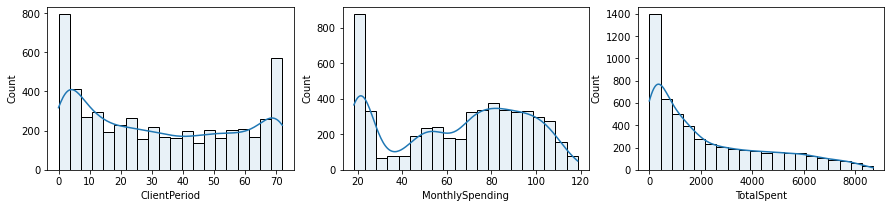

In [10]:
# Построим гистограммы

fig, ax = plt.subplots(1,3, figsize=(15,3))
counter = 0
for name in eda_data[['ClientPeriod', 'MonthlySpending', 'TotalSpent']]:
    sns.histplot(eda_data[name],kde=True, bins=20, ax=ax[counter], label=name, alpha=0.1)
    counter+=1

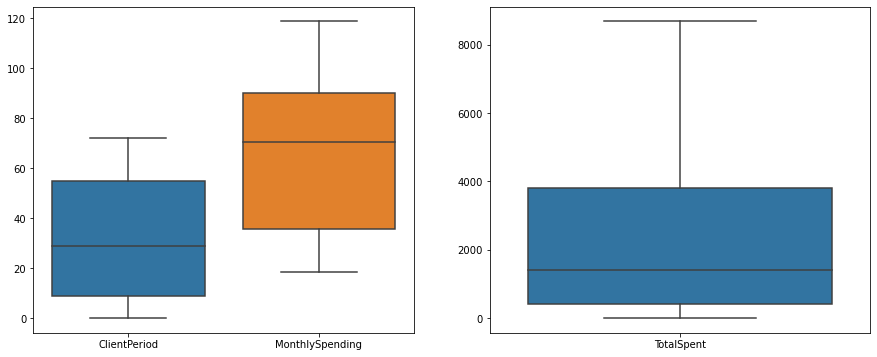

In [11]:
# Построим диаграммы размаха (они же "ящики с усами", box with whiskers)

fig,ax = plt.subplots(1,2,figsize=(15,6))
sns.boxplot(data=eda_data[['ClientPeriod','MonthlySpending']], ax=ax[0])
sns.boxplot(data=eda_data['TotalSpent'], ax=ax[1])
ax[1].set_xticklabels(["TotalSpent"])
plt.show()

**Ни одна из величин не распределена нормально, похоже что у ClientPeriod бимодальное распределение. У TotalSpent очевидная асимметрия с длинным "хвостом" справа. Но выбросов(outliers) нет, и это уже неплохо.<br><br> Нужно будет стандартизировать или нормализовать данные, попробуем несколько вариантов.**






## Теперь посмотрим на категориальные признаки

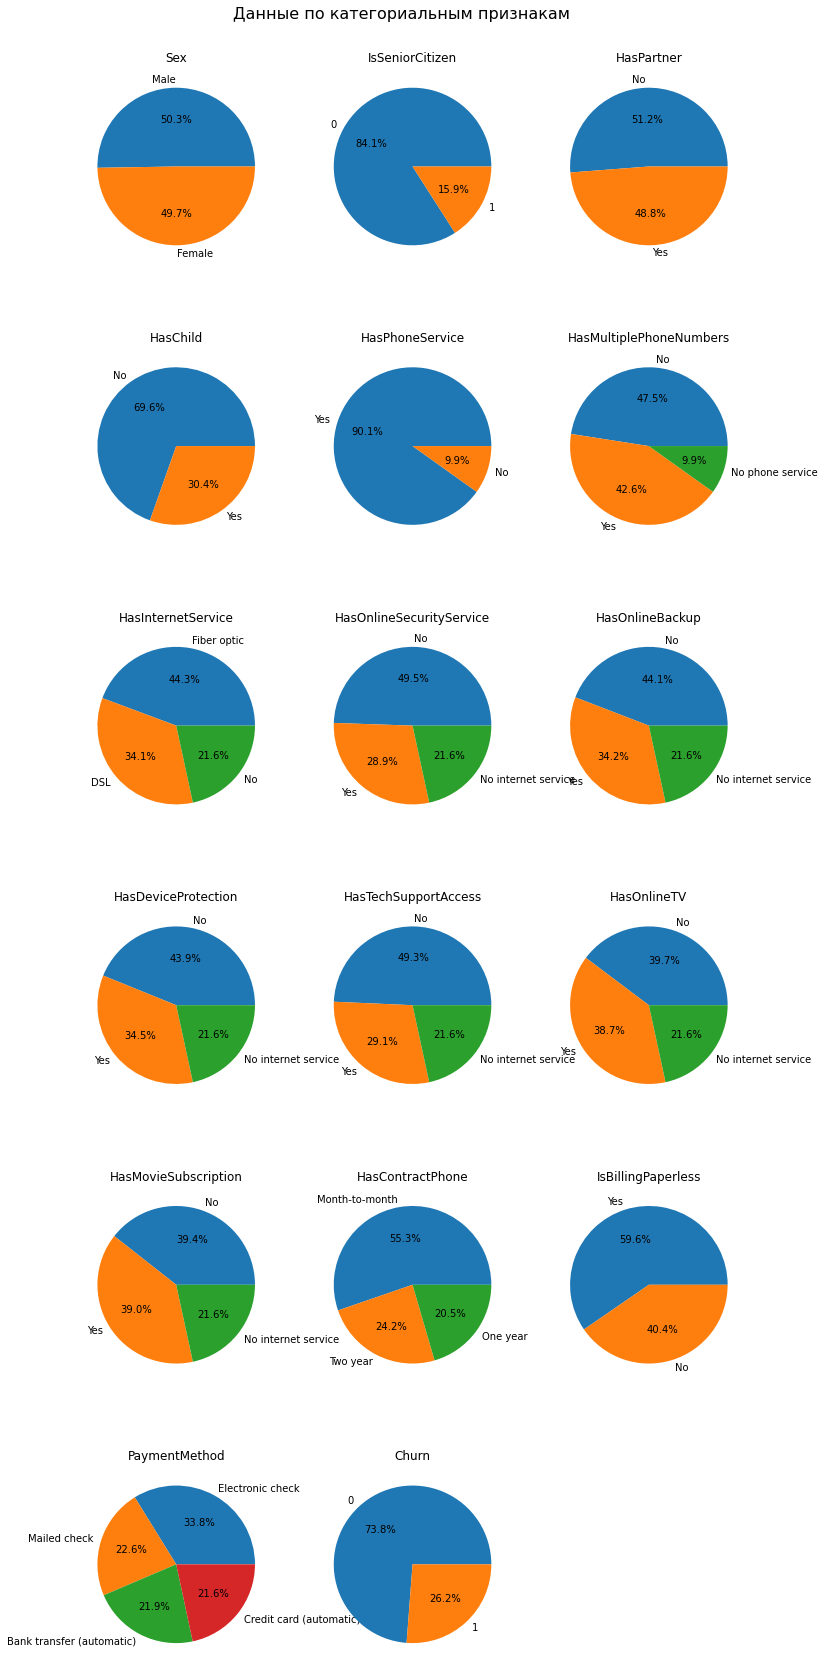

In [12]:
# Создадим временный список столбцов, добавив туда target
cols = cat_cols
cols.append(target_col)


fig, ax = plt.subplots(6,3, figsize=(12,30))
counter = 0
for i in range(6):
    for j in range(3):
        df_temp=eda_data[cols[counter]].value_counts()
        ax[i,j].pie(df_temp, autopct='%.1f%%', labels=df_temp.index)
        ax[i,j].set_title(cols[counter])
        counter += 1
        if counter > 16:
            break
# Удалим лишний "холст"            
ax[5,2].remove()
plt.suptitle('Данные по категориальным признакам', x=.5,y=.9, fontsize=16);

**Глядя на эти данные можно сразу сделать несколько выводов.**

1. **Датасет не сбалансирован**. Чуть больше четверти клиентов ушли в "отток". Это нужно будет учитвать при разбивке на тренировочную и тестовую части, а также при кросс-валидации. Необходимо будет использовать стратифицированную выборку. Я также попробую разные варианты овер- и андерсемплинга для балансировки датасета.<br><br>
2. У признаков **HasPhoneService** и **HasMultiplePhoneNumbers** дублируется категория **No phone service**. Такая же картина наблюдается со значением **No internet service** в признаках различных сервисов. Возможно есть смысл отдельно вытащить бинарный столбец с информацией о наличии-отсутствии интернета.

## Попробуем проанализировать зависимости таргета и признаков, а также сформулировать какие-нибудь гипотезы. Это может помочь создать новые признаки.

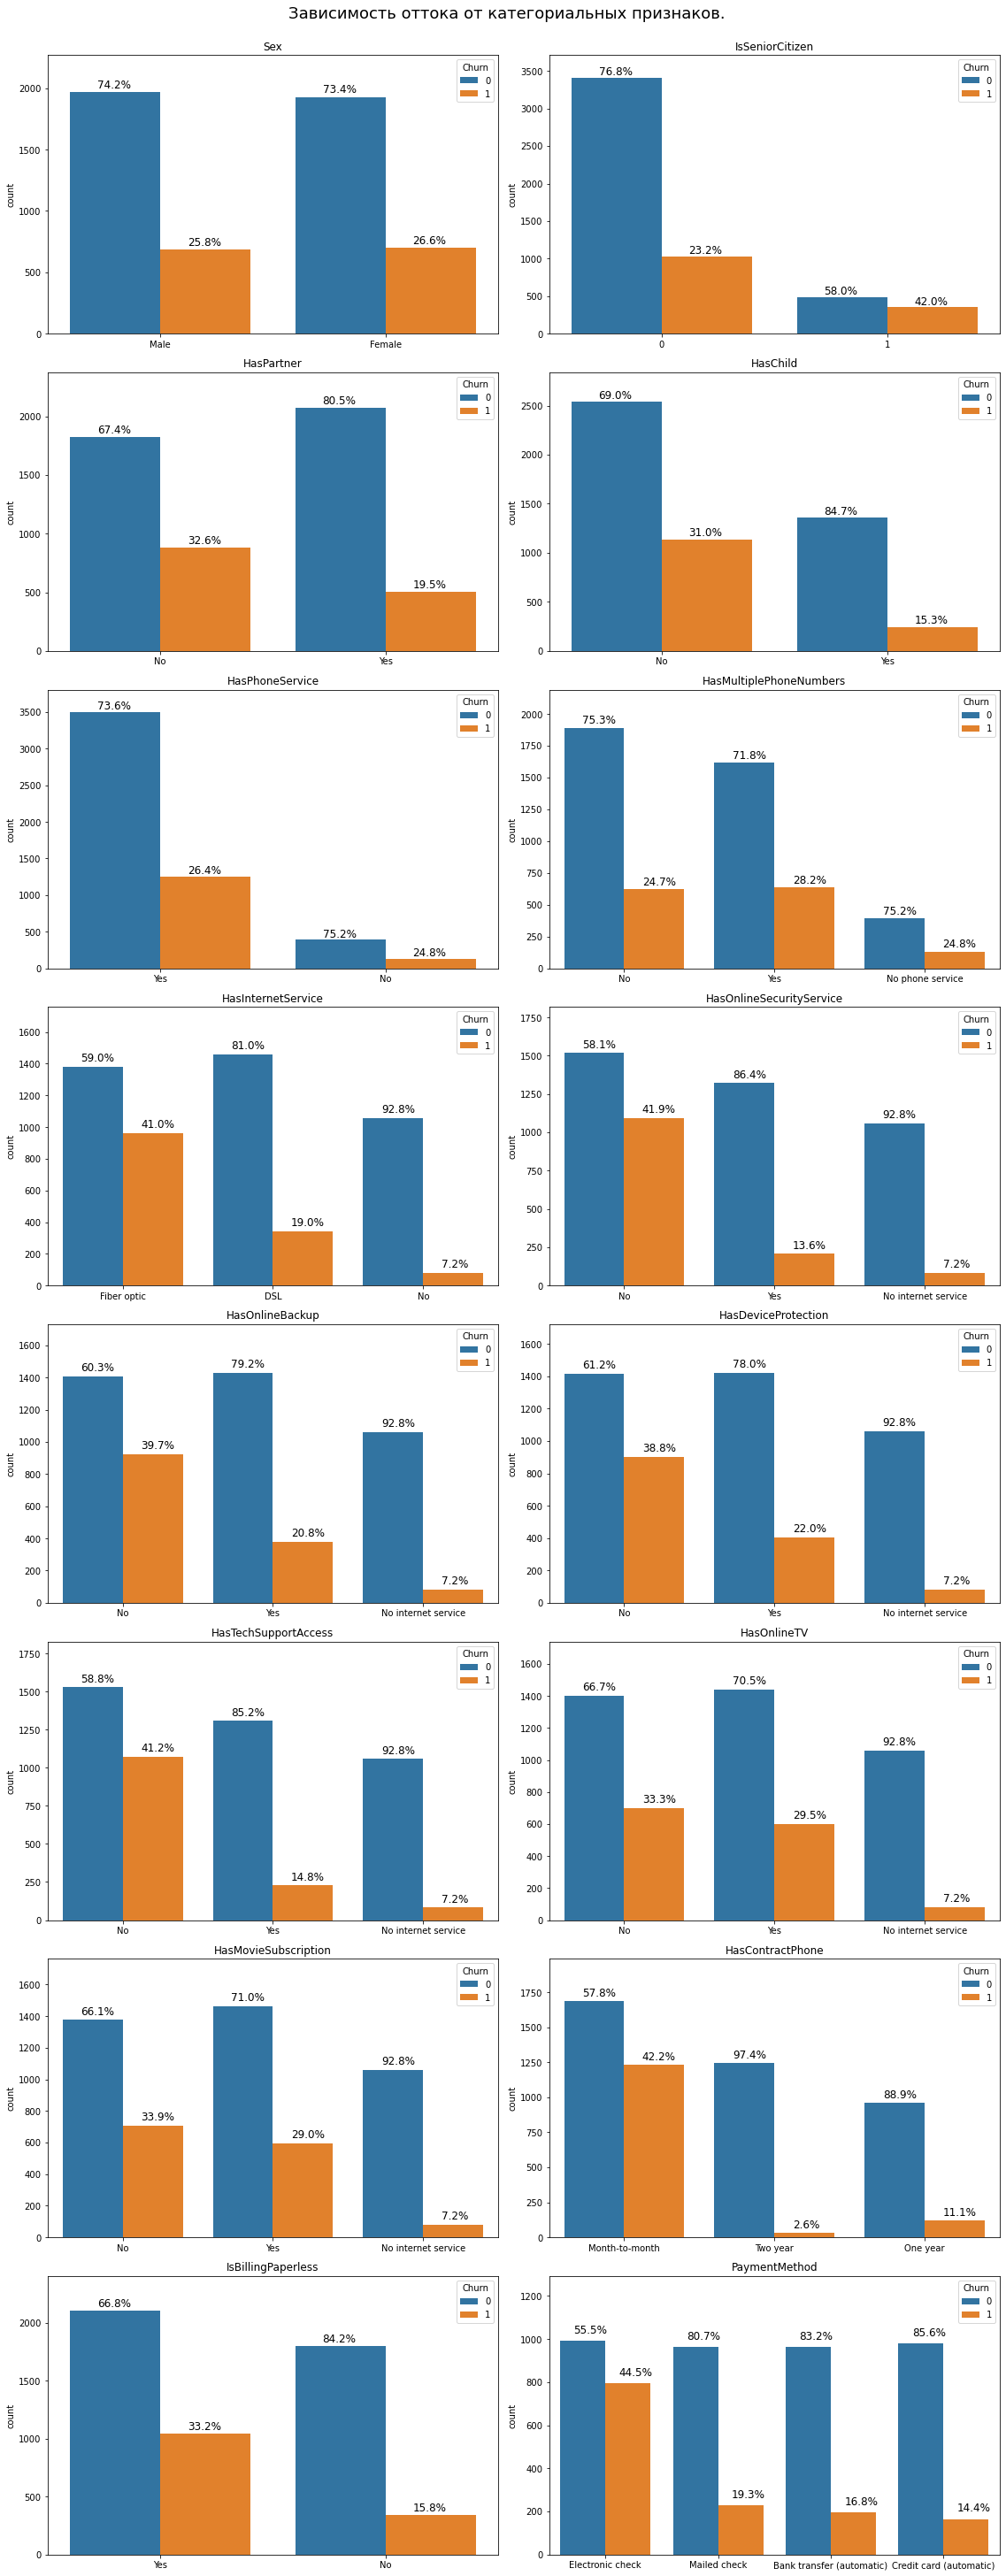

In [13]:
# Сначала посмотрим на зависимость оттока от категориальных признаков.
fig, ax = plt.subplots(8, 2, figsize=(16,40))

counter = 0
for i in range(8):
    for j in range(2):
        sns.countplot(data=eda_data, x=cat_cols[counter], hue='Churn',
                      order=eda_data[cat_cols[counter]].value_counts().sort_values(ascending=False).index,
                      ax=ax[i,j])
        
        heights = [p.get_height() for p in ax[i,j].patches]
        patch = [p for p in ax[i,j].patches]
        num_cat = eda_data[cat_cols[counter]].nunique()
        
        for n in range(num_cat):
            total = eda_data[cat_cols[counter]].value_counts().values[n]
            for m in range(2):
                percentage = '{:.1f}%'.format(100*heights[(m*num_cat + n)]/total)
                x = patch[(m*num_cat + n)].get_x() + patch[(m*num_cat + n)].get_width() / 2 - 0.08
                y = patch[(m*num_cat + n)].get_y() + patch[(m*num_cat + n)].get_height()+35
                ax[i,j].annotate(percentage, (x,y), size=12)
        
        ax[i,j].set_title(ax[i,j].get_xlabel())
        ax[i,j].set_xlabel('')
        ax[i,j].set_ylim(0,max(heights)+300)
        counter += 1
plt.tight_layout()
plt.suptitle('Зависимость оттока от категориальных признаков.', y=1.01, fontsize=18)
plt.show()

**Выводы:**
1. Пол (Sex): и среди мужчин, и среди женщин одинаковый процент пользователей уходит в "отток". Вероятно этот признак не даст никакой информации для моделей.
2. Пенсионеры(IsSeniorCitizen): Само респределение между пенсионерами и не пенсионерами сильно перекошено в сторону вторых. Но при этом среди пенсионеров почти вдвое выше процент ушедших в "отток"
3. Состоит ли в браке (HasPartner): Вполне ожидаемо, что среди людей, состоящих в браке, процент оттока существенно ниже.
4. Есть ли дети(HasChild): Тут тоже вполне ожидаемо, что у клиентов с детьми процент оттока существенно ниже. Когда у людей есть определённые обязательства, они вероятно предпочитают стабильность поиску новых вариантов.
5. Есть ли телефонная связь(HasPhoneService): Процент оттока одинаковый среди обоих типов клиентов. Похоже это вообще не влияет на вероятность "оттока"
6. Несколько телефонных номеров(HasMultiplePhoneNumbers): Среди тех клиентов, у кого есть телефонная связь, процент оттока очень близкий и среди клиентов использующих много номеров и среди тех, кто использует только один номер.
7. Тип интернета(HasInternetService): Самый низкий процент оттока среди тех клиентов, которы не пользуются интернетом вообще. А вот среди тех, кто пользуется - у клиентов на "оптоволокне" процент оттока значительно выше, чем у клиентов с ADSL.
8. Дополнительные сервисы, большая часть (OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport): Картина для всех сервисов похожая. Самый большой процент оттока у тех клиентов, у которых интернет подключён, но они по каким-то причинам конкретным сервисом не пользуются. Среди тех, у кого вообще услуги интернета не подключено - процент оттока значительно меньше.
9. Дополнительные сервисы, стриминговые услуги(OnlineTV, MovieSubscription): Тут довольно похожий процент оттока, середи тех кто пользуется сервисом, и среди тех, кто не пользуется.
10. Тип контракта(Contract): Всё также вполне ожидаемо, что наибольший процент оттока, среди тех клиентов, кто оплачивает услуги помесячно. Туда явно входят и новые клиенты. И конечно среди тех, кто сразу на долгое время контракт подписал отток существенно меньше. Причем с увеличением срока контракта - процент оттока уменьшается.
11. Услуга безбумажного биллинга(IsBillingPaperless): Процент оттока вдвое выше среди тех, кто пользуется этой услугой. Возможно стоит проверить сколько SeniorCitizen пользуется этой услугой.
12. Метод оплаты(PaymentMethod): Процент оттока существенно выше среди тех, кто осуществляет оплату электронным чеком. Остальные категории имеют довольно близки процент оттока.

## Теперь с посмотрим на зависимости оттока от числовых признаков<br>
Тут еще сразу сразу можно проверить зависят ли как-нибудь MonthlySpending и ClientPeriod от TotalSpent.

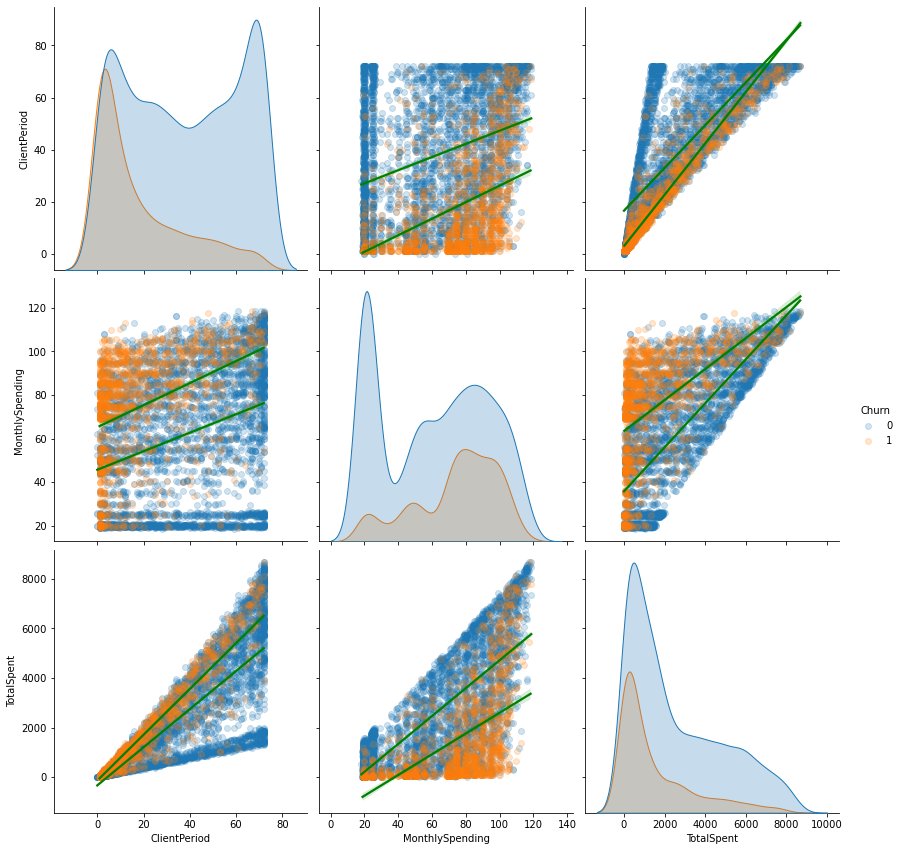

In [14]:
name_list = ['ClientPeriod','MonthlySpending','TotalSpent', 'Churn']
sns.pairplot(eda_data[name_list], hue='Churn', kind='reg', diag_kind='kde',
             plot_kws={'scatter_kws':{'alpha':0.2},'line_kws':{'color':'green'}}, height=4);

**Выводы:**
1. Зависимость оттока от ClientPeriod, MonthlySpending, TotalSpent - нелинейная. Можно попробовать сделать разбивку ClientPeriod с интервалом, например в год, и тогда для каждого интервала зависимость будет ближе к линейной. Возможно это улучшит результаты для линейных моделей. (Во всяком случае на kaggle рекомендуют попробовать и проверить)
2. Очевидно есть корреляция между парами (MonthlySpending, TotalSpent) и (ClientPeriod,TotalSpent) 

## Посмотрим на корреляцию этих признаков.<br>
Поскольку признаки численные лучше использовать коэффициент корреляции Пирсона. <br>
Спирмена и Кендалла я добавил просто для того, чтобы удостовериться, что они показывают похожие значения.

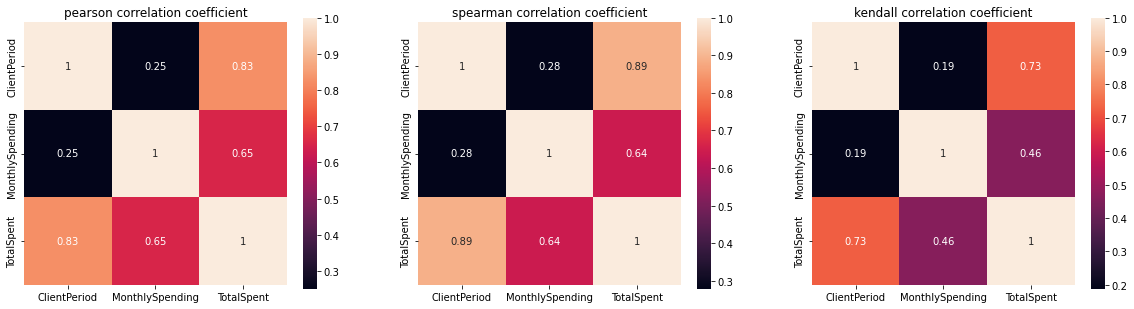

In [15]:
name_list = ['ClientPeriod','MonthlySpending','TotalSpent']
plt.figure(figsize=(20,5))
for num,name in enumerate(['pearson','spearman','kendall']):
    ax = plt.subplot(1,3,num+1)
    sns.heatmap(eda_data[name_list].corr(method=name), annot=True, square=True, ax=ax)
    plt.title(name+' correlation coefficient')

**TotalSpent заметно(по шкале Чеддока) коррелирует с MonthlySpending и ClientPeriod. Логично было бы предположить, что это вообще произведение количества месяцев в компании на месячный платеж, с мелкими отклонениями(изменение месячного платежа при смене тарифа например)**

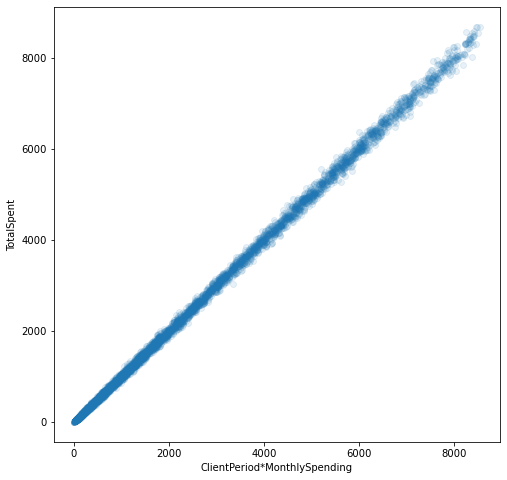

pearson correlation coefficient:           0.9995535072915906
spearman correlation coefficient:           0.9996135141794353
kendall correlation coefficient:           0.9833478448324905


In [16]:
plt.figure(figsize=(8,8))
plt.scatter(eda_data['ClientPeriod']*eda_data['MonthlySpending'],eda_data['TotalSpent'], alpha=0.1)
plt.ylabel('TotalSpent')
plt.xlabel('ClientPeriod*MonthlySpending')
plt.show()
for name in ['pearson','spearman','kendall']:
    print(f'{name} correlation coefficient: \
          {eda_data["TotalSpent"].corr(eda_data["ClientPeriod"]*eda_data["MonthlySpending"],method=name)}')

**Выводы:**

Ну в общем да, коэффициент корреляции почти единица. Конечно TotalSpent это не прямое произведение ClientPeriod и MonthlySpending, есть небольшая вариативность.<br><br>Нельзя однозначно сказать, что TotalSpent не несёт никакой дополнительной информации.<br><br> Возможно есть смысл этот признак убрать, при обучении линейных моделей. Чтобы избежать мультиколлинеарности. <br> Попробуем проверить при подборе параметров для моделей.

# Создание новых признаков. (Feature engineering)

### 1. Посчитаем общее количество сервисов, которыми пользуется клиент и посмотрим на зависимость оттока от этого количества.

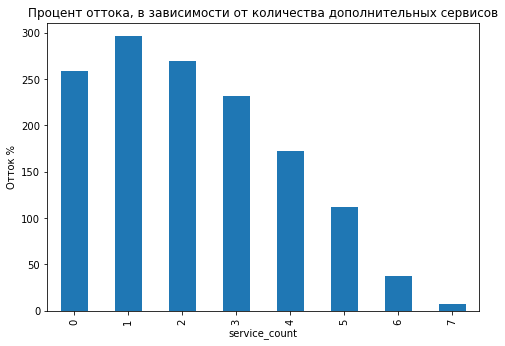

In [17]:
# Запишем в отдельный столбец количество используемых сервисов.

service_list = ['HasMultiplePhoneNumbers','HasOnlineSecurityService','HasOnlineBackup',
                'HasDeviceProtection','HasTechSupportAccess','HasOnlineTV','HasMovieSubscription']


eda_data['service_count'] = eda_data[service_list]\
                              .applymap(lambda x: 0 if x in ('No phone service', 'No internet service','No') else 1)\
                              .sum(axis=1)


eda_data.groupby('service_count')['Churn'].value_counts().unstack()[1].plot(kind='bar', ax=plt.axes((0,0,1,1)))
plt.ylabel('Отток %')
plt.title('Процент оттока, в зависимости от количества дополнительных сервисов')
plt.show()

#### Вывод 1:

Зависимость от количества используемых сервисов есть, и она нелинейная. Самый большой процент оттока у пользователей, подключивших 2 дополнительных сервиса. После 2 с увеличением числа сервисов - процент оттока уменьшается.

### 2. "Вытаскиваем" отдельно признак наличия или отсутствия интернета, так чтобы он бинарный был. И проверяем зависимость оттока от него.

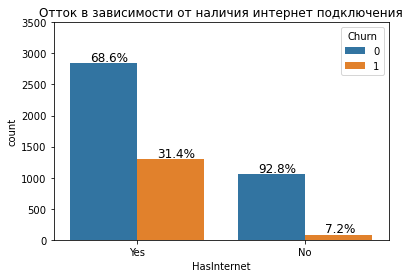

In [18]:
# Запишем в отдельный столбец наличие или отсутствие интернет подключения.

eda_data['HasInternet'] = (eda_data['HasInternetService'] != 'No').astype('int')
ax = sns.countplot(data=eda_data, x='HasInternet', hue='Churn',
                   order=eda_data['HasInternet'].value_counts().sort_values(ascending=False).index)
heights = [p.get_height() for p in ax.patches]
patch = [p for p in ax.patches]
num_cat = 2

for n in range(num_cat):
    total = eda_data['HasInternet'].value_counts().values[n]
    for m in range(2):
        percentage = '{:.1f}%'.format(100*heights[(m*num_cat + n)]/total)
        x = patch[(m*num_cat + n)].get_x() + patch[(m*num_cat + n)].get_width() / 2 - 0.08
        y = patch[(m*num_cat + n)].get_y() + patch[(m*num_cat + n)].get_height()+35
        ax.annotate(percentage, (x,y), size=12)
ax.set_ylim(0,3500)
ax.set_xticklabels(['Yes','No'])
ax.set_title('Отток в зависимости от наличия интернет подключения')
plt.show()

**Вывод 2:**

Зависимость явная, процент оттока среди пользователей, у которых есть интернет более чем в 4 раза превышает процент оттока среди тех пользователей, у которых интернета нет. 

### 3. Разбиваем ClientPeriod на интервалы по 1 году. Общая зависимость будет очевидно такая же, как без разбиения. Но для каждого интервала зависимость может стать ближе к линейной.

In [19]:
# Разобьем ClientPeriod на интервалы по 12 месяцев и запишем в отдельный столбец Preiod_bin
eda_data['Period_bin'] = pd.cut(eda_data['ClientPeriod'], bins=[-1,12,24,36,48,60,72], labels=[0,1,2,3,4,5], right=True)

# Переиндексируем столбцы , для удобства, так, чтобы у нас Churn, последним оказался.
churn = eda_data['Churn']
eda_data =  pd.concat([eda_data.drop('Churn', axis=1), churn], axis=1)
eda_data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,...,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,service_count,HasInternet,Period_bin,Churn
0,55.0,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,...,No internet service,No internet service,No internet service,One year,No,Mailed check,0,0,4,0
1,72.0,25.85,1872.20,Male,0,Yes,No,Yes,Yes,No,...,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),1,0,5,0
2,1.0,75.90,75.90,Male,0,No,No,Yes,No,Fiber optic,...,Yes,No,No,Month-to-month,Yes,Electronic check,1,1,0,1
3,32.0,79.30,2570.00,Female,1,Yes,No,Yes,Yes,Fiber optic,...,No,No,No,Month-to-month,No,Mailed check,2,1,2,0
4,60.0,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,...,Yes,Yes,Yes,Two year,No,Credit card (automatic),7,1,4,0


### **Попробуем теперь посмотреть, на взаимосвязь признаков с целевой переменной, но уже используя метрики.**

- Можно было бы посчитать корреляцию каждого признака с целевым, но дело в том, что корреляция может показать лишь линейную зависмость.
- К счастью есть еще метрика взаимной информации(**Mutual Information**). Она довольно много преимуществ имеет, одно из которых  - работа с любыми зависимостями(как линейными, так и нелинейными).

In [20]:
# Чтобы MutualInfo посчитать, сначалай прийдётся всё перевести в числовой формат
cat_list = eda_data.select_dtypes(['category']).columns.to_list()
eda_data[cat_list] = eda_data[cat_list].apply(lambda x: x.factorize()[0], axis = 0)

**Воспользуемся функцией mutual_info_classif из библиотеки sklearn.** <br>
**Она считает mutual information для категориальной целевой переменной.**

In [21]:
from sklearn.feature_selection import  mutual_info_classif

X_mi = eda_data.drop('Churn', axis=1)
y_mi = eda_data.Churn

# Для точного расчета в функцию нужно передать список столбцов (точнее список булевых значений (True, False)),
# значения которых являются дискретными. Churn у нас тоже дискретный, так что его тип поменяем на integer.
eda_data['Churn'] = eda_data['Churn'].astype('int')
discr_features = [pd.api.types.is_integer_dtype(t) for t in X_mi.dtypes]

scores = mutual_info_classif(X_mi, y_mi, discrete_features=discr_features, random_state=0)
scores_df = pd.Series(scores, name='MI scores', index=X_mi.columns)
print(scores_df.sort_values(ascending=False))

HasContractPhone            0.098413
ClientPeriod                0.070102
HasOnlineSecurityService    0.067985
Period_bin                  0.065471
HasTechSupportAccess        0.063051
HasInternetService          0.053640
TotalSpent                  0.048463
HasOnlineBackup             0.047514
MonthlySpending             0.046965
HasDeviceProtection         0.044164
PaymentMethod               0.043354
HasMovieSubscription        0.032325
HasOnlineTV                 0.031915
HasInternet                 0.031234
IsBillingPaperless          0.019698
service_count               0.019627
HasChild                    0.014347
IsSeniorCitizen             0.011380
HasPartner                  0.011123
HasMultiplePhoneNumbers     0.000780
HasPhoneService             0.000059
Sex                         0.000035
Name: MI scores, dtype: float64


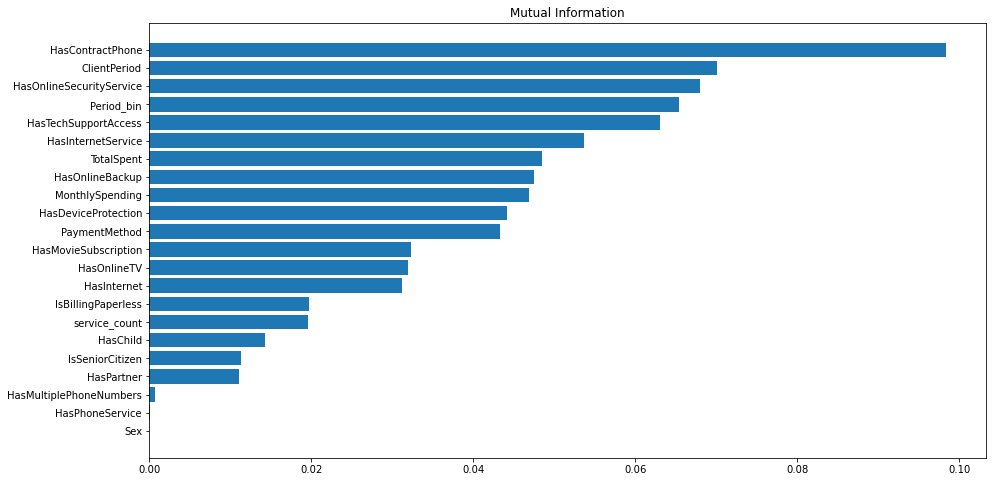

In [22]:
plt.figure(figsize=(15,8))

sorted_scores = scores_df.sort_values(ascending=True)
width = np.arange(len(sorted_scores))
ticks = list(sorted_scores.index)
plt.barh(width,sorted_scores)
plt.yticks(width,ticks)
plt.title("Mutual Information")
plt.show()

**Выводы**
- Признаков с нулевыми оценками нет. Это значит, что и Sex и HasPhoneService могут нести информацию, полезную для построения моделей. Хотя они могут и просто лишний шум привносить.
- Новые сгенерированные признаки(если не брать разбивку на годовые интервалы) - не особо много информации в себе несут. Может быть они и не дадут прироста точности для моделей. Но всё же они лучше чем те же Sex или HasPhoneService объясняют поведение целевой переменной.
- Попробуем на основании этой информации (mutual info) понизить размерность, при простроении моделей. Попробуем оставить разное количество признаков.

# Применение линейных моделей.

Импорт необходимых библиотек, модулей, функций

In [10]:


from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

# Импортируем все нужные функции метрик
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,\
                            confusion_matrix, classification_report, plot_confusion_matrix,\
                            fbeta_score, balanced_accuracy_score, plot_roc_curve, plot_precision_recall_curve

# Импортируем все необходимые модули и функции для препроцессинга данных
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, PowerTransformer,\
                                  LabelEncoder, QuantileTransformer, MinMaxScaler,\
                                  Normalizer, StandardScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline, FeatureUnion

## Так sklearn сможет показывать диаграммы пайплайнов.
from sklearn import set_config
set_config(display='diagram')

from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif, chi2
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

Функция model_score для удобной визуализации и сравнения метрик моделей.

In [11]:
# Вспомогательные функции и классы.

# ФУНКЦИЯ ДЛЯ УДОБНОЙ ВИЗУАЛИЗАЦИИ МЕТРИК МОДЕЛИ
def model_score(model, X_test, y_test):
    name = ''
    scores = {}
    scores['balanced_accuracy'] = balanced_accuracy_score(y_test, model.predict(X_test))
    scores['precision'] = precision_score(y_test, model.predict(X_test))
    scores['recall'] = recall_score(y_test, model.predict(X_test))
    scores['fbeta'] = fbeta_score(y_test, model.predict(X_test), beta=2)
    if hasattr(model,'predict_proba'):
        scores['ROC_AUC'] = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    else:
        scores['ROC_AUC'] = roc_auc_score(y_test, model.decision_function(X_test))
    if str(model).split('(')[0] == 'StackingClassifier':
        name = 'StackingClassifier'
    elif 'CatBoostClassifier' in str(model):
        name = 'CatBoostClassifier'
    else:
        name = str(model.get_params()['steps'][-1][1]).split('(')[0]
    return pd.DataFrame(scores, index=[name])

Несколько кастомных трансформеров, для генерации новых признаков(фич). Они в sklearn должны наследовать свойства двух родительских классов  - BaseEstimator и TransformerMixin

In [ ]:

# КЛАССЫ ДЛЯ ГЕНЕРАЦИИ НОВЫХ ПРИЗНАКОВ
# FIT нам в этих трансформерах не нужен, мы их не обучаем, только трансформим данные.
# В КАЖДОМ ТРАНСФОРМЕРЕ СОЗДАЁМ КОПИЮ ВХОДНЫХ ДАННЫХ, ЧТОБЫ НЕ ПОЛОМАТЬ ИСХОДНЫЙ СЕТ
# ВЫХОД РЕШЕЙПИМ К (-1,1) ЧТОБЫ ПОЛУЧИТЬ СТОЛБЕЦ А НЕ СТРОКУ

# Наличие или отсутствие интернет подключения.
class HasInternetTransformer(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_ = X.copy()
        X_.hasInternet = (X_['HasInternetService'] != 'No').astype('int')
        return X_.hasInternet.values.reshape(-1,1)

# Разбивка ClientPeriod на интервалы по 1 году.
class PeriodBinTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_ = X.copy()
        return pd.cut(X_['ClientPeriod'], bins=[-1,12,24,36,48,60,72],
                      labels=[0,1,2,3,4,5], right=True).astype('int32').values.reshape(-1,1)
    
# Подсчёт количества сервисов, используемых клиентом.
class ServiceCountTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_ = X.copy()
        service_columns = ['HasMultiplePhoneNumbers', 'HasOnlineSecurityService', 'HasOnlineBackup', 
                   'HasDeviceProtection','HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription']
        return X_[service_columns].applymap(lambda x: x == 'Yes').sum(axis=1).values.reshape(-1,1)

Фиксируем рандом

In [12]:
RANDOM_STATE = 42

Кодируем целевую переменную. К сожалению в общем случае (если не считать TransformedTragetRegression) sklearn не умеет на ходу,
внутри пайплайна этого делать.

In [13]:
X = origin_data.drop('Churn', axis=1)

# Сразу приведём TotalSpent к типу float
X['TotalSpent'] = pd.to_numeric(X['TotalSpent'], errors='coerce')
y = origin_data['Churn'].values

Делим выборку на тренировочную и валидационную части.<br>
Поскольку выборка несбалансирована, будем использовать стратификацию по y.

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, random_state=RANDOM_STATE)

Создаём кроссвал-генератор для использования в GridsearchCV и для стэкинга

In [15]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

Создаём списки категориальных и численных переменных для использования в ColumnTransformer. <br>
Вместо того, чтобы вручную прописывать все категориальные столбцы, проще и короче использовать list comprehension

In [16]:
num_features = ['ClientPeriod', 'MonthlySpending', 'TotalSpent']
cat_features = [name for name in X.columns.to_list()[2:] if name not in num_features]
print('num_features:', num_features)
print('cat_features:', cat_features)

num_features: ['ClientPeriod', 'MonthlySpending', 'TotalSpent']
cat_features: ['Sex', 'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService', 'HasMultiplePhoneNumbers', 'HasInternetService', 'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection', 'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription', 'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod']


**Пишем пайплайн препроцессинга.**

In [ ]:
# Обработка численных признаков.
num_prep = Pipeline([
                    ('scale', StandardScaler())
                    ])

# Отдельно обрабатываем TotalSpent, чтобы можно было его при подборе параметров исключить из датасета.
total_spent_prep = Pipeline([
                              ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),
                              ('scale', StandardScaler())
                              ])

# Обработка категориальных признаков
cat_prep = Pipeline([
                    ('encoding', OneHotEncoder(drop='if_binary'))
                    ])

# Собираем препроцессинг без feature engineering
preprocessing = ColumnTransformer([
                         ('num', num_prep, ['ClientPeriod','MonthlySpending']),
                         ('total_sp', total_spent_prep, ['TotalSpent']),
                         ('cat', cat_prep, cat_features)
])

# БЛОК НАШЕГО FEATURE ENGINEERING
# Генерация новых признаков
fe = FeatureUnion([
                  ('service_count', ServiceCountTransformer()),
                  ('hasInternet', HasInternetTransformer()),
                  ('period_bin', PeriodBinTransformer())
                  ])

# СОБИРАЕМ ВСЕ ЧАСТИ ПРЕПРОЦЕССИНГА ВМЕСТЕ
full_preprocessing = FeatureUnion([
                                 ('prep', preprocessing),
                                 ('engineering', fe)
                                 ])


# Тестовый пайплайн для визуализации
visualise_pipe = Pipeline([
                        ('prep_and_fe', full_preprocessing),
                        ('classif', LogisticRegression())
                        ])

# print('Вот так в общем случае будет выглядеть пайплайн')
# visualise_pipe

Вот так в общем случае будет выглядеть пайплайн:

<img src='simple_pipeline.png'>

Обучаем базовую логистическую регрессию. Пока без подбора вариантов препроцессинга и гиперпараметров.

In [18]:
%%time
simple_scores_df = pd.DataFrame()
visualise_pipe.fit(X_train,y_train)
simple_scores_df = simple_scores_df.append(model_score(visualise_pipe, X_valid, y_valid))
simple_scores_df

Wall time: 431 ms


,balanced_accuracy,precision,recall,fbeta,ROC_AUC
LogisticRegression,0.704405,0.633452,0.514451,0.534535,0.845296


Выводы:

- По roc-auc уже неплохо. Но довольно низкие recall и fbeta.
- Такой простой вариант уже даёт скор 0.84868 на kaggle в соревновании для этого сета.

Если же обучить вообще на всех данных, то скор получится ещё выше = 0.84931

In [36]:
visualise_pipe.fit(X,y); # roc-auc = 0.84931

### Подбор гиперпараметров. <br>

- Можно сразу подбирать поиском по сетке и варианты препроцессинга и гиперпараметры, но так очень большое количество комбинаций получается. В лучшем случае около 25 часов на модель получится.<br> 
- Hyperopt и Optuna могут уменьшить время поиска, иcпользуя более сложные алгоритмы, чем простой перебор всех вариантов. Но даже они не смогут ускорить поиск в несколько раз.<br>
- Поэтому будем подбирать итеративно. Сначала лучшие варианты препроцессинга. Потом уже гиперпараметры самой логистической регрессии

**Собираем полноценный пайплайн для логистической регрессии.**
- Добавим оверсемплинг, для балансировки датасета.
- Собирать будем на базе пайплайна из imbalanced_learn библиотеки. Этот пайп умеет применять оверсемплинг только к трейн части, не затрагивая тестовую или валидационную части.
- Повыбрасываем лишние признаки, на основании mutual information. Переберём разное количество фич для SelectKBest

In [37]:
lr_pipe = imbPipeline([
                        ('prep_and_fe', full_preprocessing),
                        ('sampling', SMOTE()),
                        ('select', SelectKBest(score_func=mutual_info_classif)),
                        ('classif', LogisticRegression(random_state=RANDOM_STATE, max_iter=200,
                                                       class_weight='balanced', n_jobs=-1))
                        ])

**Краткое пояснение к словарю гиперпараметров.**
- drop означает - не использовать эту часть. Таким образом можно "включать" и "выключать" препроцессинг отдельных столбцов и генерацию новых признаков.

In [38]:
# СПИСОК ДЛЯ ПЕРЕБОРА КОЛИЧЕСТВА ФИЧ В SelectKBest
# Добавляем 'all' для варианта, когда фичи вообще не нужно выбрасывать.
k_list = list(np.arange(1,18))
k_list.append('all')

# СЛОВАРЬ ПАРАМЕТРОВ ДЛЯ ПОДБОРА ЛУЧШЕГО ВАРИАНТА ПРЕПРОЦЕССИНГА
prep_params = {
      'prep_and_fe__prep__num__scale': [StandardScaler(), PowerTransformer(method='yeo-johnson')],
      'prep_and_fe__prep__total_sp': ['drop',total_spent_prep],
      'prep_and_fe__prep__cat__encoding': [OrdinalEncoder(), OneHotEncoder(drop='if_binary')],
      'prep_and_fe__engineering__service_count': ['drop',ServiceCountTransformer()],
      'prep_and_fe__engineering__hasInternet': ['drop',HasInternetTransformer()],
      'prep_and_fe__engineering__period_bin': ['drop',PeriodBinTransformer()],
      'select__k': k_list,
      'sampling': ['drop',SMOTE(random_state=RANDOM_STATE), ADASYN(random_state=RANDOM_STATE),
                  SMOTEENN(random_state=RANDOM_STATE)],
}

# Создаем объект для подбора параметров препроцессинга для логистической регрессии
prep_lr_gs = GridSearchCV(estimator=lr_pipe, param_grid=prep_params, scoring='roc_auc', cv=skf, n_jobs=-1, verbose=10)

Подбираем параметры препроцессинга

In [39]:
%%time
prep_lr_gs.fit(X_train, y_train)
prep_lr_gs.best_params_

Fitting 5 folds for each of 4608 candidates, totalling 23040 fits
Wall time: 46min 5s


{'prep_and_fe__engineering__hasInternet': 'drop',
 'prep_and_fe__engineering__period_bin': PeriodBinTransformer(),
 'prep_and_fe__engineering__service_count': 'drop',
 'prep_and_fe__prep__cat__encoding': OneHotEncoder(drop='if_binary'),
 'prep_and_fe__prep__num__scale': PowerTransformer(),
 'prep_and_fe__prep__total_sp': 'drop',
 'sampling': SMOTE(random_state=42),
 'select__k': 'all'}

Подбираем гиперпараметры для самой логистической регрессии.

In [129]:
full_lr_params = {
#       'prep_and_fe__prep__num__scale': [PowerTransformer(method='yeo-johnson')],
#       'prep_and_fe__prep__total_sp': ['drop'],
#       'prep_and_fe__prep__cat__encoding': [OneHotEncoder(drop='if_binary')],
#       'prep_and_fe__engineering__service_count': ['drop'],
#       'prep_and_fe__engineering__hasInternet': ['drop'],
#       'prep_and_fe__engineering__period_bin': [PeriodBinTransformer()],
#       'select__k': ['all'],
#       'sampling': [SMOTE(random_state=RANDOM_STATE)],
      'classif__penalty': ['l1','l2','elasticnet'],
      'classif__C': np.arange(0.1,1.1,0.1),
      'classif__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
}

# Создаем объект для подбора параметров препроцессинга для логистической регрессии
full_lr_gs = GridSearchCV(estimator=prep_lr_gs.best_estimator_, param_grid=full_lr_params,
                          scoring='roc_auc',
                          refit='roc_auc',cv=skf, n_jobs=-1, verbose=10)

In [130]:
%%time
full_lr_gs.fit(X, y)
print(f'Best ROC-AUC = {full_lr_gs.best_score_}')

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best ROC-AUC = 0.848182555390693
Wall time: 3min 20s


Результат: 

- Такая модель уже даёт скор **0.85188** на kaggle

# Применение градиентного бустинга

In [55]:
from catboost import CatBoostClassifier

### Обучаем простой CatBoostClassifet без препроцессинга данных и подбора гиперпараметров.

In [56]:
%%time
simple_catboost = CatBoostClassifier()
simple_catboost.fit(X_train, y_train, cat_features=cat_features, verbose=False)
model_score(simple_catboost, X_valid, y_valid)

Wall time: 46.4 s


,balanced_accuracy,precision,recall,fbeta,ROC_AUC
CatBoostClassifier,0.700676,0.637363,0.50289,0.525045,0.843812


Результат:

- Не смотря на то, что метрики хуже, чем у логистической регрессии - эта модель даёт скор 0.85261 на kaggle

### Подбираем гиперпараметры для CatBoostClassifie

In [151]:
%%time
cb_model = CatBoostClassifier(cat_features=cat_features, verbose=False, loss_function='Logloss',
                              eval_metric='AUC:hints=skip_train~false', random_seed=RANDOM_STATE)

cb_grid = {'learning_rate': [0.01,0.05,0.1],
        'num_trees':[300],
       'depth':[4,6,8,10],
        'l2_leaf_reg': [1, 3],}

cb_gs = GridSearchCV(estimator=cb_model, param_grid=cb_grid, scoring='roc_auc', cv=skf, n_jobs=-1, verbose=10)
cb_gs.fit(X,y)

print(f'Best ROC-AUC = {cb_gs.best_score_}')

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best ROC-AUC = 0.8465899364692688
Wall time: 7min 39s


Результат:

- Такая модель уже даёт на kaggle скор **0.85377**
### Это лучший скор, которого удалось достичь

# Экспериментируем с другими моделями и ансамблированием.

### Попробуем 7 разных моделей, подберём для них лучшие варианты препроцессинга и гиперпараметры.<br> Соберём стэкинг над всеми 7 моделями и посмотрим на результаты.

#### Импорт необходимых библиотек, модулей и функций

In [79]:
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

#### Собираем пайплайн с минимальным препроцессингом. Будем использовать результат как baseline.

In [ ]:
# Минимальный препроцессинг
minimal_prep = ColumnTransformer(
                                [('num', SimpleImputer(missing_values=np.nan,strategy='constant', fill_value=0), num_features),
                                 ('cat', OneHotEncoder(), cat_features)]
                                )

# Теперь создадим пайплайны для для базовых моделей. Все параметры по-умолчанию.
# Логистическая регрессия
simple_lr = Pipeline(steps=[('preprocessing', minimal_prep),
                            ('classifier', LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1))])
# К-ближайших соседей
simple_knn = Pipeline(steps=[('preprocessing', minimal_prep),
                             ('classifier', KNeighborsClassifier(n_jobs=-1))])
# Решающие деревья
simple_dtc = Pipeline(steps=[('preprocessing', minimal_prep),
                             ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE))])
# Случайный лес
simple_rfc = Pipeline(steps=[('preprocessing', minimal_prep),
                             ('classifier', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))])

# Метод опорных векторов (в дальнейшем попробуем разные функции ядра использовать, но пока по умолчанию rbf)
simple_svc = Pipeline(steps=[('preprocessing', minimal_prep),
                             ('classifier', SVC(probability=True,random_state=RANDOM_STATE))])
# Байесовский классификатор
simple_nb = Pipeline(steps=[('preprocessing', minimal_prep),
                             ('classifier', GaussianNB())])
# Градиентный бустинг
simple_xgb = Pipeline(steps=[('preprocessing', minimal_prep),
                             ('classifier', XGBClassifier(use_label_encoder=False,random_state=RANDOM_STATE, n_jobs=-1))])
simple_models_list = [('lr',simple_lr), ('knn',simple_knn), ('dtc',simple_dtc), ('rfc',simple_rfc),
                      ('svc',simple_svc), ('nb', simple_nb), ('xgb',simple_xgb)]
# Стэкинг
simple_stacking = StackingClassifier(estimators=simple_models_list, cv=skf, n_jobs=-1)

# print('Вот так общая схема выглядит')
# simple_stacking

Так выглядит общая схема:

<img src='stacking_pipeline.png'>

Обучение

In [83]:
%%time
# Обучим модели и посчитаем базовые метрики.
scoring_list = [simple_lr, simple_knn, simple_dtc, simple_rfc, simple_svc, simple_nb, simple_xgb, simple_stacking]

simple_scores_df = pd.DataFrame()
for model in scoring_list:
    model.fit(X_train,y_train)
    simple_scores_df = simple_scores_df.append(model_score(model, X_valid, y_valid))

simple_scores_df.sort_values(by=['ROC_AUC','recall'], ascending=False)
simple_scores_df

[05:19:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 26.2 s


,balanced_accuracy,precision,recall,fbeta,ROC_AUC
LogisticRegression,0.715220,0.655914,0.528902,0.550210,0.843636
KNeighborsClassifier,0.637977,0.539370,0.395954,0.418193,0.717251
DecisionTreeClassifier,0.652053,0.503106,0.468208,0.474795,0.652053
RandomForestClassifier,0.690560,0.627820,0.482659,0.506061,0.822306
SVC,0.500000,0.000000,0.000000,0.000000,0.778823
GaussianNB,0.739961,0.458333,0.826590,0.712151,0.821744
XGBClassifier,0.695595,0.646154,0.485549,0.510949,0.819874
StackingClassifier,0.700582,0.631769,0.505780,0.526791,0.840150


Результат:

- SVC не сошёлся вообще, вероятно из-за мультиколлинеарности. Нужно TotalSpent выбрасывать для этой конкретной модели.
- В остальном LogReg, RandomForest, наивный Байес, бустниг на XGB и стэкинг всех моделей показывают очень неплохие результаты.

#### Собираем полноценные пайплайны.

In [84]:
# Создадим полные пайплайны для всех 7 моделей.
# Логистическая регрессия
lr_pipe = imbPipeline([
                        ('prep_and_fe', full_preprocessing),
                        ('sampling', SMOTE()),
                        ('select', SelectKBest(score_func=mutual_info_classif)),
                        ('classif', LogisticRegression(random_state=RANDOM_STATE, max_iter=200,
                                                       class_weight='balanced', n_jobs=-1))
                        ])

# К-ближайших соседей
knn_pipe = imbPipeline([
                        ('prep_and_fe', full_preprocessing),
                        ('sampling', SMOTE()),
                        ('select', SelectKBest(score_func=mutual_info_classif)),
                        ('classif', KNeighborsClassifier(n_jobs=-1))
                        ])

# Решающие деревья
dtc_pipe = imbPipeline([
                        ('prep_and_fe', full_preprocessing),
                        ('sampling', SMOTE()),
                        ('select', SelectKBest(score_func=mutual_info_classif)),
                        ('classif', DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
                        ])

# Случайный лес
rfc_pipe = imbPipeline([
                        ('prep_and_fe', full_preprocessing),
                        ('sampling', SMOTE()),
                        ('select', SelectKBest(score_func=mutual_info_classif)),
                        ('classif', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced'))
                        ])

# Метод опорных векторов
svc_pipe = imbPipeline([
                        ('prep_and_fe', full_preprocessing),
                        ('sampling', SMOTE()),
                        ('select', SelectKBest(score_func=mutual_info_classif)),
                        ('classif', SVC(random_state=RANDOM_STATE, class_weight='balanced'))
                        ])

# Байесовский классификатор
nb_pipe = test_pipe = imbPipeline([
                        ('prep_and_fe', full_preprocessing),
                        ('sampling', SMOTE()),
                        ('select', SelectKBest(score_func=mutual_info_classif)),
                        ('classif', GaussianNB())
                        ])

# Градиентный бустинг
xgb_pipe = imbPipeline([
                        ('prep_and_fe', full_preprocessing),
                        ('sampling', SMOTE()),
                        ('select', SelectKBest(score_func=mutual_info_classif)),
                        ('classif', XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1))
                        ])

#### Подбираем варианты препроцессинга.

In [85]:
# Логистическая регрессия
prep_lr_gs = GridSearchCV(estimator=lr_pipe, param_grid=prep_params, scoring='roc_auc', cv=skf, n_jobs=-1, verbose=3)

# К-ближайших соседей
prep_knn_gs = GridSearchCV(estimator=knn_pipe, param_grid=prep_params, scoring='roc_auc', cv=skf, n_jobs=-1, verbose=3)

# Решающие деревья
prep_dtc_gs = GridSearchCV(estimator=dtc_pipe, param_grid=prep_params, scoring='roc_auc', cv=skf, n_jobs=-1, verbose=3)

# Случайный лес
prep_rfc_gs = GridSearchCV(estimator=rfc_pipe, param_grid=prep_params, scoring='roc_auc', cv=skf, n_jobs=-1, verbose=3)

# Метод опорных векторов
prep_svc_gs = GridSearchCV(estimator=svc_pipe, param_grid=prep_params, scoring='roc_auc', cv=skf, n_jobs=-1, verbose=3)

# Байесовский классификатор
# Тут параметры только для препроцессинга подбираем.
prep_nb_gs = GridSearchCV(estimator=nb_pipe, param_grid=prep_params, scoring='roc_auc', cv=skf, n_jobs=-1, verbose=3)

# Градиентный бустинг
prep_xgb_gs = GridSearchCV(estimator=xgb_pipe, param_grid=prep_params, scoring='roc_auc', cv=skf, n_jobs=-1, verbose=3)

In [86]:
%%time
# Подбираем лучшие варианты препроцессинга для каждой модели.
# Список наших gridsearch-моделей.
prep_gs_list = [prep_lr_gs, prep_knn_gs, prep_dtc_gs, prep_rfc_gs, prep_svc_gs, prep_nb_gs, prep_xgb_gs]

for model in prep_gs_list:
    model.fit(X, y)
    print('best_score = ', model.best_score_)

Fitting 5 folds for each of 4608 candidates, totalling 23040 fits
best_score =  0.8480934516061513
Fitting 5 folds for each of 4608 candidates, totalling 23040 fits
best_score =  0.8004772793284405
Fitting 5 folds for each of 4608 candidates, totalling 23040 fits
best_score =  0.78271571393113
Fitting 5 folds for each of 4608 candidates, totalling 23040 fits
best_score =  0.8351678317748314
Fitting 5 folds for each of 4608 candidates, totalling 23040 fits
best_score =  0.8337491618095834
Fitting 5 folds for each of 4608 candidates, totalling 23040 fits
best_score =  0.836717101416968
Fitting 5 folds for each of 4608 candidates, totalling 23040 fits
[17:09:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best_score =  0.835234669652252
W

#### Подбираем гиперпараметры для самих моделей

In [158]:
# Логистическая регрессия
full_lr_params = {
      'classif__penalty': ['l1','l2','elasticnet'],
      'classif__C': np.arange(0.1,1.1,0.1),
      'classif__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],      
}

gslr = GridSearchCV(estimator=prep_lr_gs.best_estimator_, param_grid=full_lr_params,
                    scoring='roc_auc', cv=skf, n_jobs=-1, verbose=3)

# К-ближайших соседей
full_knn_params = {
      'classif__n_neighbors': np.arange(2,10),
      'classif__algorithm': ['ball_tree', 'kd_tree', 'brute'],
      'classif__weights': ['uniform','distance'],      
}

gsknn = GridSearchCV(estimator=prep_knn_gs.best_estimator_, param_grid=full_knn_params,
                     scoring='roc_auc', cv=skf, n_jobs=-1, verbose=3)

# Решающие деревья
full_dtc_params = {
      'classif__criterion': ['gini','entropy'],
      'classif__splitter': ['best', 'random'],
      'classif__max_features': ['sqrt', 'log2'],
      'classif__min_samples_leaf': np.arange(1,1000,10),

}

gsdtc = GridSearchCV(estimator=prep_dtc_gs.best_estimator_, param_grid=full_dtc_params,
                     scoring='roc_auc', cv=skf, n_jobs=-1, verbose=3)

# Случайный лес
full_rfc_params = {
      'classif__n_estimators': np.arange(100,301,50),
      'classif__criterion': ['gini', 'entropy'],
      'classif__max_features': ['sqrt', 'log2'],
      'classif__min_samples_leaf': np.arange(1,1000,10),

}

gsrfc = GridSearchCV(estimator=prep_rfc_gs.best_estimator_, param_grid=full_rfc_params,
                     scoring='roc_auc', cv=skf, n_jobs=-1, verbose=3)

# Метод опорных векторов
full_svc_params = {
      'sampling': [SMOTEENN(random_state=RANDOM_STATE)],
      'classif__C': np.arange(0.1,1.1,0.1),
      'classif__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

gssvc = GridSearchCV(estimator=prep_svc_gs.best_estimator_, param_grid=full_svc_params,
                     scoring='roc_auc', cv=skf, n_jobs=-1, verbose=3)

# Градиентный бустинг
full_xgb_params = {
      'classif__n_estimators': np.arange(100,301,100),
      'classif__learning_rate': [0.001,0.01, 0.05,0.1],
      'classif__max_depth': [4,6,8],
      'classif__reg_lambda': [1,2,3],
}

gsxgb = GridSearchCV(estimator=prep_xgb_gs.best_estimator_, param_grid=full_xgb_params,
                     scoring='roc_auc', cv=skf, n_jobs=-1, verbose=3)

In [160]:
%%time
# Выведем лучшие параметры для моделей
full_gs_list = [gslr, gsknn, gsdtc, gsrfc, gssvc, gsxgb]
names_list = ['Logistic Regression','K-neighbors classifier', 'Decision tree classifier',
              'Random forest classifier','Support vector classifier', 'XGBoost']
for name, model in zip(names_list,full_gs_list):
    model.fit(X, y)
    print(f'\n{name} Best ROC-AUC = {model.best_score_}')
#     print(pd.Series(model.best_params_))

Fitting 5 folds for each of 150 candidates, totalling 750 fits

Logistic Regression Best ROC-AUC = 0.8481263299535788
Fitting 5 folds for each of 48 candidates, totalling 240 fits

K-neighbors classifier Best ROC-AUC = 0.8135419378664327
Fitting 5 folds for each of 800 candidates, totalling 4000 fits

Decision tree classifier Best ROC-AUC = 0.8081480192163649
Fitting 5 folds for each of 2000 candidates, totalling 10000 fits

Random forest classifier Best ROC-AUC = 0.8419389929615745
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Support vector classifier Best ROC-AUC = 0.842429009008119
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[21:56:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

XGBoost Best ROC

#### Собираем стэкинг и подбираем гиперпараметры. В качестве метаалгоритма используем логистическую регрессию.

In [162]:
%%time
## Теперь попробуем найти лучшие гиперпараметры для финального алгоритма в StackingClassifier
## В данном случае для логистической регрессии.
stacking_list = [('lr',gslr.best_estimator_), ('knn',gsknn.best_estimator_), ('dtc',gsdtc.best_estimator_),
                  ('rfc',gsrfc.best_estimator_), ('svc', gssvc.best_estimator_), ('nb', prep_nb_gs.best_estimator_),
                  ('xgb', gsxgb.best_estimator_)]
final_stacking = StackingClassifier(estimators=stacking_list,
                                    final_estimator = LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1),
                                    cv=skf, n_jobs=-1)
fs_grid = {'final_estimator__penalty': ['l1','l2','elasticnet'],
      'final_estimator__C': np.arange(0.1,1.1,0.1),
      'final_estimator__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}  
fsgs = GridSearchCV(estimator=final_stacking, param_grid=fs_grid, cv=5, n_jobs=-1, scoring='roc_auc', verbose=3)
fsgs.fit(X, y)
print(f'Best ROC-AUC = {fsgs.best_score_}')
# print('Best params for Stacking')
# print(fsgs.best_params_)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best ROC-AUC = 0.8476017148357577
Wall time: 3h 2min 52s


### Итоговый результат

In [223]:
final_models_list = [gslr,gsknn,gsdtc,gsrfc,gssvc,prep_nb_gs,gsxgb,fsgs]

scores_dict = {'model_name':[], 'ROC_AUC':[]}
for model in final_models_list:
    if hasattr(model.best_estimator_, 'final_estimator'):
        scores_dict['model_name'].append(str(model.best_estimator_).split('(')[0])
    else:
        scores_dict['model_name'].append(str(model.best_estimator_._final_estimator).split('(')[0])
    scores_dict['ROC_AUC'].append(model.best_score_)
scores_df = pd.DataFrame(scores_dict)
scores_df

,model_name,ROC_AUC
0,LogisticRegression,0.848126
1,KNeighborsClassifier,0.813542
2,DecisionTreeClassifier,0.808148
3,RandomForestClassifier,0.841939
4,SVC,0.842429
5,GaussianNB,0.836717
6,XGBClassifier,0.842661
7,StackingClassifier,0.847602


Собираем сабмиты для kaggle.

In [220]:
X_test = pd.read_csv('test.csv')
X_test['TotalSpent'] = pd.to_numeric(X_test['TotalSpent'], errors='coerce')
submission = pd.read_csv('submission.csv')

# best_model.predict_proba(X_test) / best_model.predict(X_test)
for model in final_models_list:
    if hasattr(model,'predict_proba'):
        submission['Churn'] = model.best_estimator_.predict_proba(X_test)[:,1]
    else:
        submission['Churn'] = model.best_estimator_.decision_function(X_test)
    if hasattr(model.best_estimator_, 'final_estimator'):
        submission.to_csv(str(model.best_estimator_).split('(')[0]+'.csv', index=False)
    else:
        submission.to_csv(str(model.best_estimator_._final_estimator).split('(')[0]+'.csv', index=False)

Сравниваем результаты.

In [228]:
scores_df['kaggle_score'] = [0.85107, 0.81762, 0.79143, 0.84220, 0.84765, 0.82223, 0.84093, 0.85153]
scores_df.sort_values(by='kaggle_score', ascending=False)

,model_name,ROC_AUC,kaggle_score
7,StackingClassifier,0.847602,0.85153
0,LogisticRegression,0.848126,0.85107
4,SVC,0.842429,0.84765
3,RandomForestClassifier,0.841939,0.84220
6,XGBClassifier,0.842661,0.84093
5,GaussianNB,0.836717,0.82223
1,KNeighborsClassifier,0.813542,0.81762
2,DecisionTreeClassifier,0.808148,0.79143


Вывод: 

Лучший скор получился на стэкинге. Хотя он и ниже, чем у CatBoost после подбора гиперпараметров.